In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import cv2
from lxml import etree
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import datasets, models

from draw import show_img
from boundingbox import bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh, \
                        bbox_xywh_to_cxcywh, bbox_xywh_to_x1y1x2y2, CoordinateType, FormatType, BoundingBoxConverter

import transforms

# Utils

In [2]:
def getImgGrid(img_list, cols=2):
    num_img, height, width, channel = img_list.shape
    rows = num_img // cols
    # target = (height * rows, width * cols, channel)
    grid = img_list.reshape(rows, cols, height, width, channel)\
                    .transpose(0, 2, 1, 3, 4)\
                    .reshape(height * rows, width * cols, channel)
    return grid

# Sample image and labels

In [3]:
from imgaug import augmenters as iaa
import imgaug as ia
import numpy as np
label_xml_path = './custom_data/7_x_wing.xml'
img_path = './output/x_wing_0391.jpg'
img_path = './custom_data/x_wing/x_wing_0384.jpg'

In [4]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

org_dim = img.shape[1], img.shape[0]
net_dim = (416, 416)

org_dim, net_dim


((1280, 546), (416, 416))

In [5]:
# Sample labels for './custom_data/x_wing/x_wing_0384.jpg'
# Format : x1y1x2y2, Absolute
label = np.array([[   0.  ,  870.84,   66.63,  975.61,  129.49],
                  [   0.  , 1122.01,    0.  , 1276.65,  116.92],
                  [   0.  ,  587.54,  104.35,  695.67,  172.24],
                  [   0.  ,   57.83,  176.43,  290.  ,  279.52],
                  [   0.  ,  150.45,  117.76,  824.74,  427.46],
                  [   0.  ,  256.47,   28.92,  396.45,  123.63]])

bbs = transforms.label_np_to_bbs(label, img.shape, [1,2,3,4])

# Show image

(<matplotlib.axes._subplots.AxesSubplot at 0x7fea98a71b70>, (546, 1280, 3))

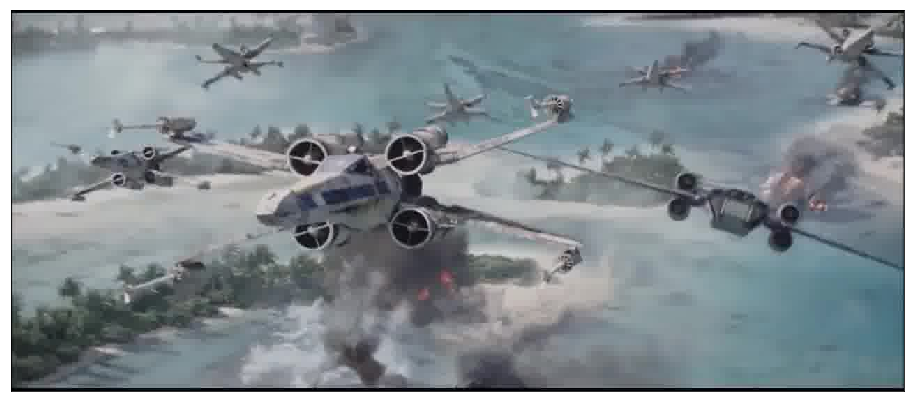

In [6]:
show_img(img,  figsize=(16,8)), img.shape

# Letterbox transforms (Revisit)

## Using OpenCV

### Image

In [7]:
"""Returns the new dimension, padding and ratio required to perform a keep-aspect ratio resize
    Args:
        org_w, org_h: width and height of the original image
        new_w, new_h: width and height of the target image
"""
def letterbox_transforms(org_w, org_h, new_w, new_h):
    ratio = min(new_w / org_w, new_h / org_h)
    resize_w, resize_h = int(org_w * ratio), int(org_h * ratio)
    x_off, y_off = (new_w - resize_w) // 2, (new_h - resize_h) // 2
    return resize_w, resize_h, x_off, y_off, ratio

In [8]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


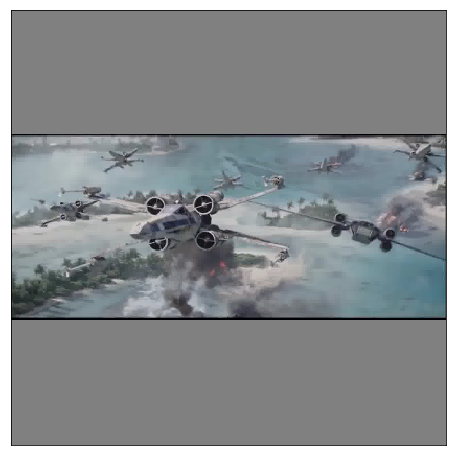

In [9]:
new_dim = (416, 416)
org_w, org_h = img.shape[1], img.shape[0]
new_w, new_h = new_dim[1], new_dim[0]
resize_w, resize_h, x_off, y_off, ratio = letterbox_transforms(org_w, org_h, new_w, new_h)
resize_img = cv2.resize(img, (resize_w, resize_h), interpolation = cv2.INTER_CUBIC)
#letterbox_img = cv2.copyMakeBorder(resize_img, y_off, y_off, x_off, x_off, cv2.BORDER_CONSTANT, value=(128,128,128))

#Put the box image on top of the blank image
letterbox_img = np.full(new_dim +(3,), 128)
letterbox_img[y_off:y_off+resize_h, x_off:x_off+resize_w] = resize_img
show_img(letterbox_img,  figsize=(16,8))

### Labels

In [10]:
# Sample labels for './custom_data/x_wing/x_wing_0384.jpg'
label = np.array([[   0.  ,  870.84,   66.63,  975.61,  129.49],
                  [   0.  , 1122.01,    0.  , 1276.65,  116.92],
                  [   0.  ,  587.54,  104.35,  695.67,  172.24],
                  [   0.  ,   57.83,  176.43,  290.  ,  279.52],
                  [   0.  ,  150.45,  117.76,  824.74,  427.46],
                  [   0.  ,  256.47,   28.92,  396.45,  123.63]])
img_dim = img.shape[1], img.shape[0]
label, img_dim

(array([[   0.  ,  870.84,   66.63,  975.61,  129.49],
        [   0.  , 1122.01,    0.  , 1276.65,  116.92],
        [   0.  ,  587.54,  104.35,  695.67,  172.24],
        [   0.  ,   57.83,  176.43,  290.  ,  279.52],
        [   0.  ,  150.45,  117.76,  824.74,  427.46],
        [   0.  ,  256.47,   28.92,  396.45,  123.63]]), (1280, 546))

In [11]:
label[..., 1:5] = bbox_x1y1x2y2_to_cxcywh(label[..., 1:5])
label

array([[   0.   ,  923.225,   98.06 ,  104.77 ,   62.86 ],
       [   0.   , 1199.33 ,   58.46 ,  154.64 ,  116.92 ],
       [   0.   ,  641.605,  138.295,  108.13 ,   67.89 ],
       [   0.   ,  173.915,  227.975,  232.17 ,  103.09 ],
       [   0.   ,  487.595,  272.61 ,  674.29 ,  309.7  ],
       [   0.   ,  326.46 ,   76.275,  139.98 ,   94.71 ]])

In [12]:
def letterbox_labels(labels, x_off, y_off, resize_dim, new_dim, bbs_idx=np.arange(0,4)):
    if isinstance(labels, torch.Tensor): 
        labels = labels.clone()
    elif isinstance(labels, np.ndarray):
        labels = labels.copy()
    else:
        raise TypeError("Labels must be a numpy array or pytorch tensor")
    ratio_x = resize_dim[0] / new_dim[0]
    ratio_y = resize_dim[1] / new_dim[1]
    x_idx, y_idx, cxw_idx, cyh_idx = bbs_idx[0], bbs_idx[1], bbs_idx[[0,2]], bbs_idx[[1,3]]    
    labels[..., cxw_idx] *= ratio_x 
    labels[..., cyh_idx] *= ratio_y 
    labels[..., x_idx] += x_off
    labels[..., y_idx] += y_off

    return labels

In [13]:
# Convert the coordinates from absolute to relative format
bbs_idx = np.arange(1,5)
x_idx, y_idx = bbs_idx[[0,2]], bbs_idx[[1,3]] 
label[..., x_idx] = label[..., x_idx] / org_w
label[..., y_idx] = label[..., y_idx] / org_h
x_off, y_off = x_off / new_w, y_off / new_h
label

array([[0.        , 0.72126953, 0.17959707, 0.08185156, 0.11512821],
       [0.        , 0.93697656, 0.1070696 , 0.1208125 , 0.21413919],
       [0.        , 0.50125391, 0.25328755, 0.08447656, 0.12434066],
       [0.        , 0.13587109, 0.41753663, 0.18138281, 0.18880952],
       [0.        , 0.38093359, 0.49928571, 0.52678906, 0.56721612],
       [0.        , 0.25504688, 0.1396978 , 0.10935937, 0.17346154]])

In [14]:
label = letterbox_labels(label, x_off, y_off, (resize_w, resize_h), (new_w, new_h), bbs_idx)
label

array([[0.        , 0.72126953, 0.36247279, 0.08185156, 0.04898484],
       [0.        , 0.93697656, 0.33161375, 0.1208125 , 0.09111211],
       [0.        , 0.50125391, 0.39382667, 0.08447656, 0.05290456],
       [0.        , 0.13587109, 0.4637115 , 0.18138281, 0.08033482],
       [0.        , 0.38093359, 0.49849416, 0.52678906, 0.24133955],
       [0.        , 0.25504688, 0.34549642, 0.10935937, 0.07380455]])

In [15]:
def cv2_drawTextWithBkgd(img, text, bt_left_pt, color, max_x, max_y, font_scale=2.0, font=cv2.FONT_HERSHEY_PLAIN):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, fontScale=font_scale, thickness=1)[0]
        
    t_pt1 = np.clip(bt_left_pt[0], 0, max_x - text_width), np.clip(bt_left_pt[1], text_height, max_y) 
    t_pt2 = t_pt1[0] + text_width, t_pt1[1] - text_height
    
    img = cv2.rectangle(img, t_pt1, t_pt2, color, cv2.FILLED, 4)
    img = cv2.putText(img, text, t_pt1, cv2.FONT_HERSHEY_PLAIN, fontScale=font_scale, color=(0, 0, 0), thickness=1);
    return img

In [16]:
def get_color_pallete(num_color):
    cmap = plt.get_cmap('tab20b')
    colors = np.array([cmap(i) for i in np.linspace(0, 1, num_color)])
    bbox_colors = colors[torch.randperm(num_color)]
    return bbox_colors

In [17]:
def draw_labels_on_image(img, labels, classes_names, bbox_colors, thickness=1, font_scale=0.7, font=cv2.FONT_HERSHEY_PLAIN):
    for l in labels:
        if l.sum() == 0:
            break;

        box_coord = l[1:5]
        cls = l[0]

        cls_text = classes_names[cls.int().item()]
        cls_color = bbox_colors[cls.int()]

        box_coord = bbox_cxcywh_to_x1y1x2y2(box_coord.clone())

        box_coord[[0,2]] = box_coord[[0,2]] * img.shape[1]
        box_coord[[1,3]] = box_coord[[1,3]] * img.shape[0]

        pt1 = tuple(box_coord[0:2].int().numpy())
        pt2 = tuple(box_coord[2:4].int().numpy())

        img = cv2.rectangle(img, pt1, pt2, cls_color, thickness)
        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img.shape[1], img.shape[0], font_scale=font_scale, font=font)

    show_img(img, figsize=(16,8))

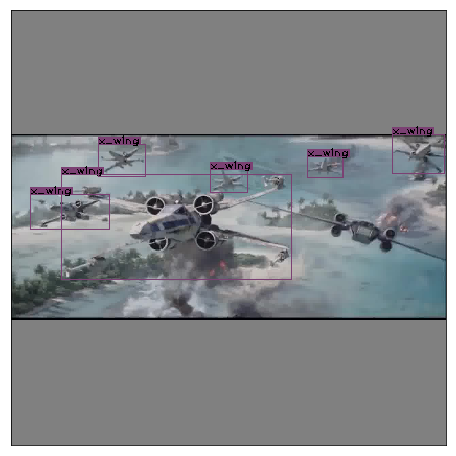

In [18]:
#We expect the output of the network to be torch.Tensors
draw_labels_on_image(letterbox_img / 255, torch.from_numpy(label), ['x_wing', 'tie'], get_color_pallete(20))

## Using imguag

In [19]:
def iaa_letterbox(img, new_dim):
    if isinstance(img, tuple):
        org_dim = img
    else:
        org_dim = img.shape[1], img.shape[0]
    
    resize_w, resize_h, x_pad, y_pad, ratio = transforms.letterbox_transforms(*org_dim, *new_dim)
    l_pad, r_pad = x_pad, new_dim[0] - resize_w - x_pad
    t_pad, b_pad = y_pad, new_dim[1] - resize_h - y_pad

    return iaa.Sequential([iaa.Scale({ "width": resize_w, "height": resize_h }),
                           iaa.Pad(px=(t_pad, r_pad, b_pad, l_pad), keep_size=False, pad_cval=128),
                          ])

def iaa_reverse_letterbox(org_dim, new_dim):
    org_dim = (img.shape[1], img.shape[0])
    resize_w, resize_h, x_pad, y_pad, ratio = transforms.letterbox_transforms(*org_dim, *new_dim)
    l_pad, r_pad = x_pad, new_dim[0] - resize_w - x_pad
    t_pad, b_pad = y_pad, new_dim[1] - resize_h - y_pad

    return iaa.Sequential([iaa.Crop(px=(t_pad, r_pad, b_pad, l_pad), keep_size=False),
                           iaa.Scale({ "width": org_dim[0], "height": org_dim[1] }),
                          ])



(<matplotlib.axes._subplots.AxesSubplot at 0x7fea1c2802e8>, (416, 416, 3))

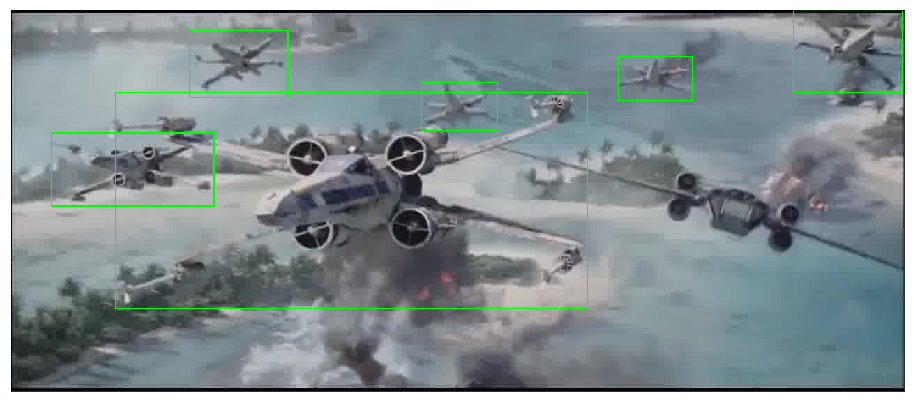

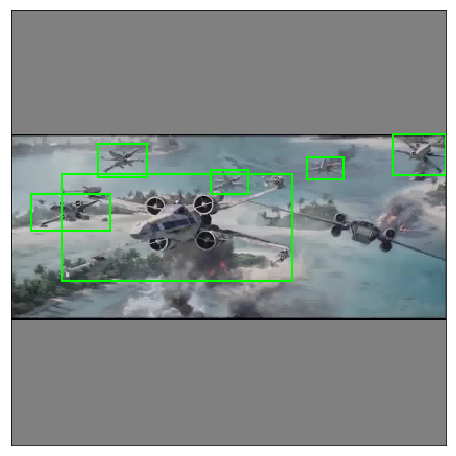

In [20]:
org_dim = img.shape[1], img.shape[0]
seq = iaa.Sequential([iaa_letterbox(org_dim, net_dim)])
seq = seq.to_deterministic()

letterbox_img = seq.augment_images([img])[0]
letterbox_bbs = seq.augment_bounding_boxes([bbs])[0]

bbs_img = bbs.draw_on_image(img, thickness=2)
letterbox_bbs_img = letterbox_bbs.draw_on_image(letterbox_img, thickness=2)

show_img(bbs_img,  figsize=(16,8)), bbs_img.shape
show_img(letterbox_bbs_img,  figsize=(16,8)), letterbox_bbs_img.shape

# imgaug transforms (iaa)

## HSV - deal with hue, saturation, exposure in darknet cfg file

In [21]:
"""
    Follow darknet format:darknet/src/http_stream.cpp
    
         hsv[1] *= dsat; 
         hsv[2] *= dexp; 
         hsv[0] += 179 * dhue; 

"""
def iaa_hsv_aug(hue=0, saturation=1, exposure=1):
    h_l, h_t = 179 * -hue, 179 * hue
    s_l, s_t = 1 / saturation if saturation else 0, saturation
    v_l, v_t = 1 / exposure if exposure else 0, exposure
    
    return iaa.Sequential([iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
                           iaa.WithChannels([0], iaa.Add((h_l, h_t))),
                           iaa.WithChannels([1], iaa.Multiply((s_l, s_t))),
                           iaa.WithChannels([2], iaa.Multiply((v_l, v_t))),
                           iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")])



(<matplotlib.axes._subplots.AxesSubplot at 0x7fea1c2332b0>, (546, 1280, 3))

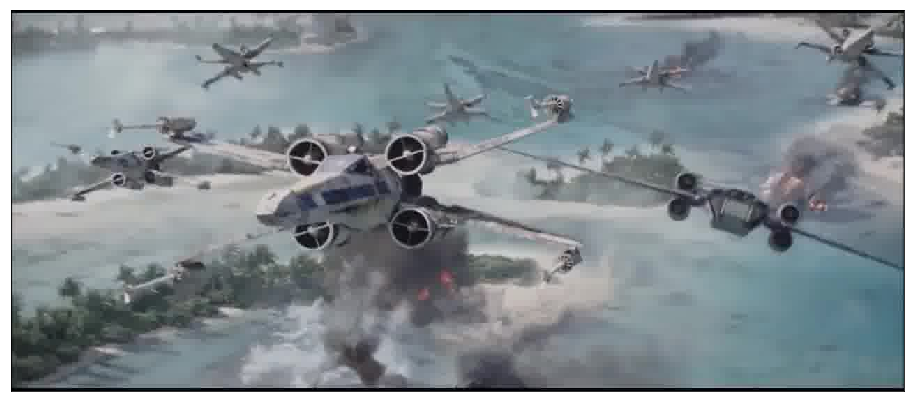

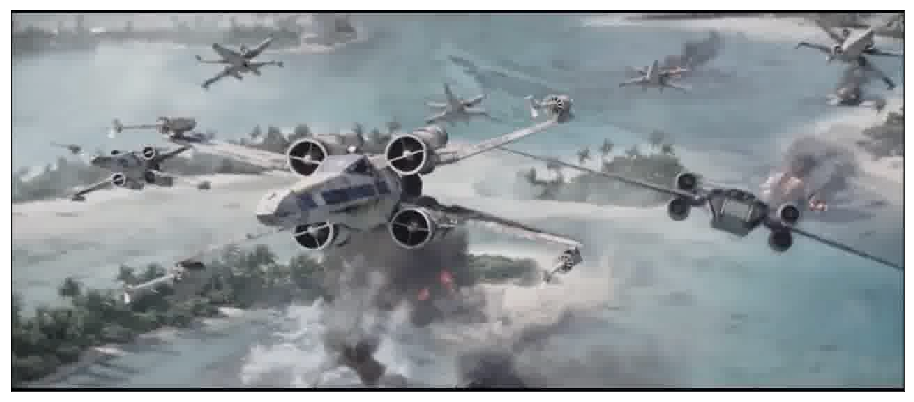

In [22]:
ia.seed(np.random.randint(0, 2**16))

seq = iaa.Sequential([iaa_hsv_aug(0, 1.5, 1.5)])
seq = seq.to_deterministic()

hsv_img = seq.augment_images([img])[0]

show_img(img,  figsize=(16,8)), img.shape
show_img(hsv_img,  figsize=(16,8)), hsv_img.shape

## Flip horizontally

(<matplotlib.axes._subplots.AxesSubplot at 0x7fea1c230080>, (546, 1280, 3))

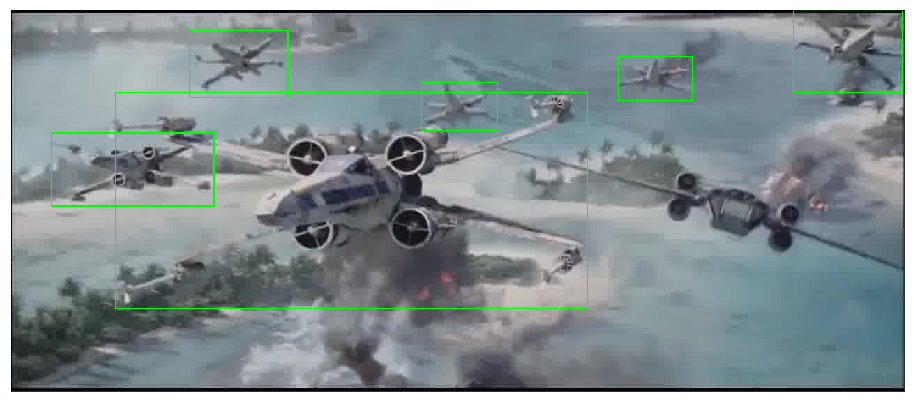

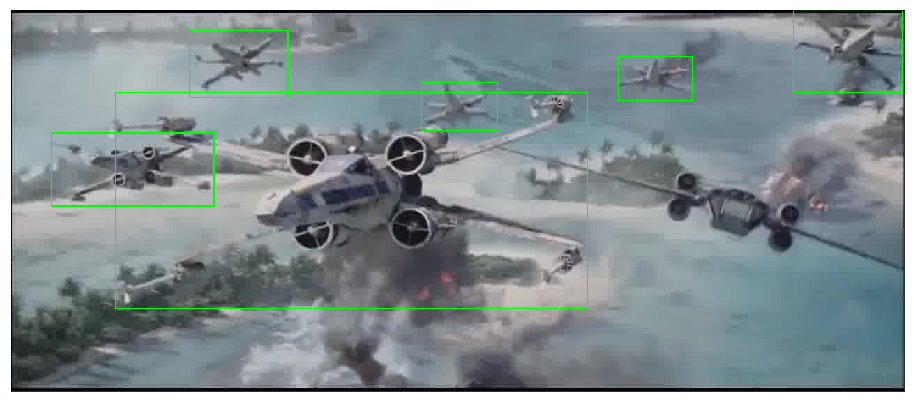

In [23]:
ia.seed(np.random.randint(0, 2**16))

seq = iaa.Sequential([iaa.Fliplr(0.5)])
seq = seq.to_deterministic()

aug_img = seq.augment_images([img])[0]
aug_bbs = seq.augment_bounding_boxes([bbs])[0]

bbs_img = bbs.draw_on_image(img, thickness=2)
aug_bbs_img = aug_bbs.draw_on_image(aug_img, thickness=2)

show_img(bbs_img,  figsize=(16,8)), bbs_img.shape
show_img(aug_bbs_img,  figsize=(16,8)), aug_bbs_img.shape

## Random Crop - jitter in cfg file

In [24]:
"""
 From darknet/src/data.c
 
 int dw = (ow*jitter); 
 int dh = (oh*jitter); 
  
 int pleft  = rand_uniform_strong(-dw, dw); 
 int pright = rand_uniform_strong(-dw, dw); 
 int ptop   = rand_uniform_strong(-dh, dh); 
 int pbot   = rand_uniform_strong(-dh, dh); 
  
 int swidth =  ow - pleft - pright; 
 int sheight = oh - ptop - pbot; 
"""

def iaa_random_crop(jitter):
    return iaa.Sequential([iaa.Crop(None, ((0,jitter),(0,jitter), (0,jitter), (0,jitter)), keep_size=False)])

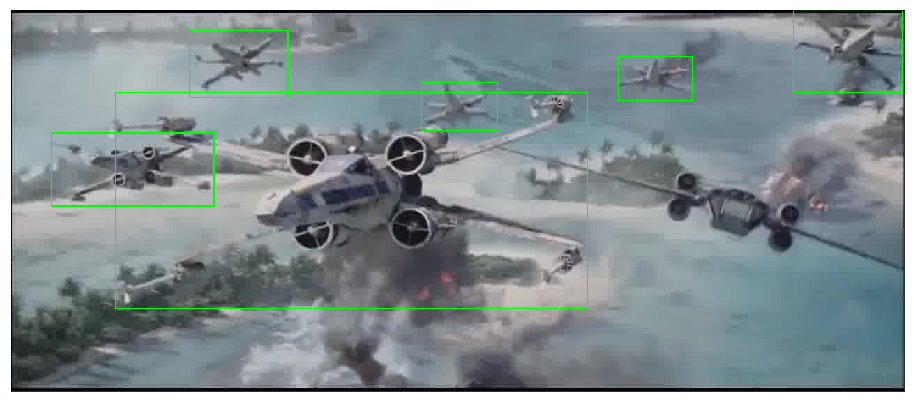

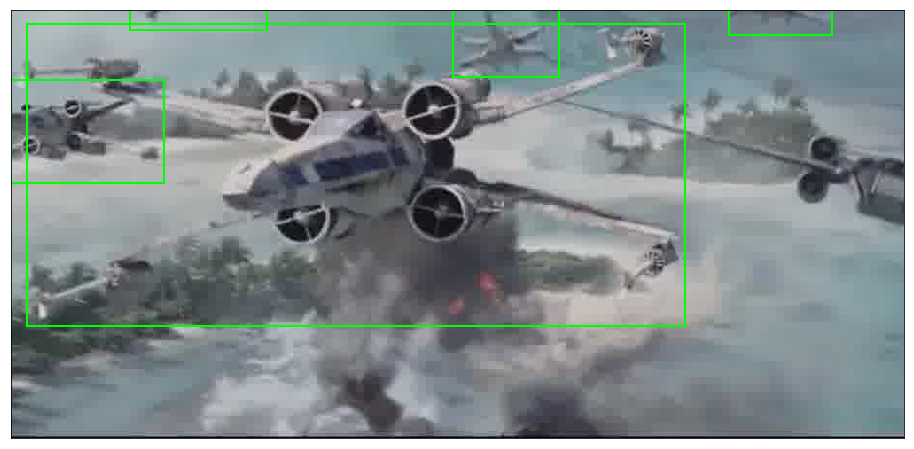

In [25]:
ia.seed(np.random.randint(0, 2**16))
seq_crop = iaa_random_crop(0.3).to_deterministic()

aug_crop_img = seq_crop.augment_images([img])[0]
aug_crop_bbs = seq_crop.augment_bounding_boxes([bbs])[0]
aug_crop_bbs = aug_crop_bbs.remove_out_of_image().cut_out_of_image()

crop_dim = aug_crop_img.shape[1], aug_crop_img.shape[0]
#seq_crop_letterbox = iaa.Sequential([iaa_letterbox(crop_dim, net_dim)])

#aug_crop_letterbox_img = seq_crop_letterbox.augment_images([aug_crop_img])[0]
#aug_crop_letterbox_bbs = seq_crop_letterbox.augment_bounding_boxes([aug_crop_bbs])[0]


bbs_img = bbs.draw_on_image(img, thickness=2)
aug_crop_bbs_img = aug_crop_bbs.draw_on_image(aug_crop_img, thickness=2)
#aug_crop_letterbox_bbs_img = aug_crop_letterbox_bbs.draw_on_image(aug_crop_letterbox_img, thickness=2)


show_img(bbs_img,  figsize=(16,8))
show_img(aug_crop_bbs_img,  figsize=(16,8))
#show_img(aug_crop_letterbox_bbs_img,  figsize=(16,8)), aug_crop_img.shape, aug_crop_letterbox_img.shape

## COCO YoloV3 Augmentations
     hsv         -> hue, saturation, exposure
     crop        -> jitter
     fliplr      -> flip horizontally
     letterbox   -> letterbox resize
     

In [26]:
# Simple function to run the sequential augmentations on both image and bounding boxes
def iaa_run_seq(seq, img, bbs=None):
    aug_bbs = None
    aug_img = seq.augment_images([img])[0]
    if bbs:
        aug_bbs = seq.augment_bounding_boxes([bbs])[0]
        aug_bbs = bbs_remove_cut_out(aug_bbs, 0.2)
    return aug_img, aug_bbs

# Remove bounding boxes that are out of the image
# If a bounding box is partially out of the image, it is determined by "bbs_clipped / bbs_original > area_thr"
def bbs_remove_cut_out(bbs, area_thr):
    bbs_clean = [bbs_clip(b, bbs.shape, area_thr) for b in bbs.bounding_boxes]
    bbs_clean = list(filter(None.__ne__, bbs_clean))
    return ia.BoundingBoxesOnImage(bbs_clean, shape=bbs.shape)


# Clip bounding boxes coordinates that are out of image
def bbs_clip(bbs, shape, area_thr=0):
    height, width = shape[0:2]

    eps = np.finfo(np.float32).eps
    x1 = np.clip(bbs.x1, 0, width - eps)
    x2 = np.clip(bbs.x2, 0, width - eps)
    y1 = np.clip(bbs.y1, 0, height - eps)
    y2 = np.clip(bbs.y2, 0, height - eps)

    area = (x2 - x1) * (y2 - y1)
    keep = area / bbs.area

    if keep > area_thr:
        return bbs.copy(
            x1=x1,
            y1=y1,
            x2=x2,
            y2=y2,
            label=bbs.label
        )
    else:
        return None

In [27]:
baseSeq = iaa.Sequential([iaa_hsv_aug(0.1, 1.5, 1.5),
                          iaa_random_crop(0.3),
                          iaa.Fliplr(0.5)]).to_deterministic()

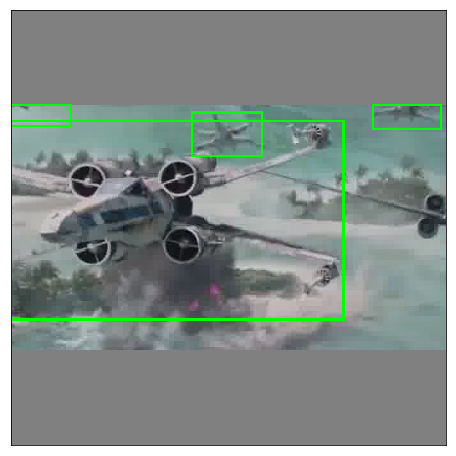

In [28]:
aug_img, aug_bbs = iaa_run_seq(baseSeq, img, bbs)
aug_img, aug_bbs = iaa_run_seq(iaa_letterbox(aug_img, (416, 416)), aug_img, aug_bbs)

aug_img = aug_bbs.draw_on_image(aug_img, thickness=2)
show_img(aug_img,  figsize=(16,8))

# Putting everything together to be used for datasets

**Compose a sequence of transformations**

In [29]:
class Compose():
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

** Convert input(numpy array) to torch.Tensor **

In [30]:
class ToTensor():
    def __init__(self, max_labels=50, max_label_cols=5):
        self.max_labels = max_labels
        self.max_label_cols = max_label_cols

    def __call__(self, sample):
        img, org_img, label = sample.get('img', None), sample.get('org_img', None), sample.get('label', None)

        img = torch.from_numpy(img).float().permute(2,0,1) / 255.0 if img is not None else None
        org_img = torch.from_numpy(org_img).float().permute(2,0,1) / 255.0 if org_img is not None else None
        label = torch.from_numpy(fill_label_np_tensor(label, self.max_labels, self.max_label_cols))

        sample.update({'img': img, 'org_img': org_img, 'label': label})
        return sample
    
def fill_label_np_tensor(label, row, col):
    label_tmp = np.full((row, col), 0.0)
    if label is not None:
        length = label.shape[0] if label.shape[0] < row else row
        label_tmp[:length] = label[:length]
    return label_tmp

** Convert np labels to bbs, vice versa **

In [31]:
class ToIaa():
    def __init__(self, bbs_idx=[1,2,3,4], seed=None):
        if seed is None:
            seed = np.random.randint(0, 2**16)

        self.bbs_idx = bbs_idx
        self.seed = seed
        
        ia.seed(self.seed)

    def __call__(self, sample):
        img, label = sample['img'], sample['label']
        bbs = None
        if label is not None:
            bbs = label_np_to_bbs(label, img.shape, bbs_idx=self.bbs_idx)
        sample.update({'img': img, 'label': label, 'bbs':bbs})
        return sample
    
class ToNp():
    def __init__(self, bbs_idx=[1,2,3,4]):
        self.bbs_idx = bbs_idx

    def __call__(self, sample):
        img, label, bbs = sample['img'], sample['label'], sample['bbs']
        if label is not None:
            label = label_bbs_to_np(bbs, bbs_idx=self.bbs_idx)
        sample.update({'img': img.copy(), 'label': label, 'bbs':bbs})
        return sample
    
def label_np_to_bbs(label, shape, bbs_idx=np.arange(0,4)):
    # Filter bounding boxes that doesn't satisfy x2 > x1 and y2 > y1 
    bbs = ((b[bbs_idx[0]], b[bbs_idx[1]], b[bbs_idx[2]], b[bbs_idx[3]], b) for b in label if b[bbs_idx[2]] > b[bbs_idx[0]] and b[bbs_idx[3]] > b[bbs_idx[1]])
    bbs = [ia.BoundingBox(x1=b[0], y1=b[1], x2=b[2], y2=b[3], label=b[4]) for b in bbs]
    bbs = ia.BoundingBoxesOnImage(bbs, shape=shape)
    return bbs

def label_bbs_to_np(bbs, bbs_idx=np.arange(0,4)):
    if len(bbs.bounding_boxes) == 0:
        return None

    row = len(bbs.bounding_boxes)
    col = bbs.bounding_boxes[0].label.shape[0]
    label = np.zeros((row, col))
    for i, b in enumerate(bbs.bounding_boxes):
        label_row = b.label
        label_row[..., bbs_idx] = [b.x1, b.y1, b.x2, b.y2]
        label[i] = label_row
    return label

** Iaa Augmentations **

In [32]:
class ToIaa():
    def __init__(self, bbs_idx=[1,2,3,4], seed=None):
        if seed is None:
            seed = np.random.randint(0, 2**16)

        self.bbs_idx = bbs_idx
        self.seed = seed
        
        ia.seed(self.seed)

    def __call__(self, sample):
        img, label = sample['img'], sample['label']
        bbs = None
        if label is not None:
            bbs = label_np_to_bbs(label, img.shape, bbs_idx=self.bbs_idx)
        sample.update({'img': img, 'label': label, 'bbs':bbs})
        return sample


class IaaAugmentations():
    def __init__(self, aug_list):
        self.seq = iaa.Sequential(aug_list)


    def __call__(self, sample):
        img, label, bbs = sample['img'], sample['label'], sample['bbs']
        seq = self.seq.to_deterministic()
        img, bbs = iaa_run_seq(seq, img, bbs)
        sample.update({'img': img, 'label': label, 'bbs':bbs})
        return sample

** Letterbox transform **

In [33]:
def iaa_letterbox(img, new_dim):
    if isinstance(img, tuple):
        org_dim = img
    else:
        org_dim = img.shape[1], img.shape[0]
    
    padded_w, padded_h, x_pad, y_pad, ratio = letterbox_transforms(*org_dim, *new_dim)
    l_pad, r_pad = x_pad, new_dim[0] - padded_w - x_pad
    t_pad, b_pad = y_pad, new_dim[1] - padded_h - y_pad
    lb_reverter = np.array([org_dim[0], org_dim[1], padded_w, padded_h, x_pad, y_pad])

    return iaa.Sequential([iaa.Scale({ "width": padded_w, "height": padded_h }),
                           iaa.Pad(px=(t_pad, r_pad, b_pad, l_pad), keep_size=False, pad_cval=128),
                          ]), \
           lb_reverter
    
class IaaLetterbox():
    def __init__(self, new_dim):
        super().__init__()
        self.new_dim = new_dim

    def __call__(self, sample):
        org_img, label, bbs = sample['img'], sample['label'], sample['bbs']
        seq, lb_reverter = iaa_letterbox(org_img, self.new_dim)
        seq = seq.to_deterministic()
        img, bbs = iaa_run_seq(seq, org_img, bbs)
        sample.update({'img': img, 'org_img': org_img.copy(), 'label': label, 'bbs':bbs, 'lb_reverter':lb_reverter})
        return sample

** BoundingBoxes Coordinates / Format Type Conversion **

In [34]:
class BoundingBoxFormatConvert(object):
    def __init__(self, src_coord_type, src_format_type,
                       dest_coord_type, dest_format_type,
                       bbox_idx):
        self.src_coord_type = src_coord_type
        self.src_format_type = src_format_type
        self.dest_coord_type = dest_coord_type
        self.dest_format_type = dest_format_type
        self.bbox_idx = bbox_idx

    def __call__(self, sample):
        img, label = sample['img'], sample['label']
        img_dim = img.shape[1], img.shape[0]

        if label is not None:
            label = BoundingBoxConverter.convert(label,
                                                 self.src_coord_type, self.src_format_type,
                                                 self.dest_coord_type, self.dest_format_type,
                                                 self.bbox_idx,
                                                 img_dim
                                                )

        sample.update({'img': img, 'label': label})
        return sample

    def reverse(self):
        rev = copy.copy(self)
        rev.src_coord_type = self.dest_coord_type
        rev.src_format_type = self.dest_format_type
        rev.dest_coord_type = self.src_coord_type
        rev.dest_format_type = self.src_format_type
        return rev

class ToX1y1x2y2Abs(BoundingBoxFormatConvert):
    def __init__(self, src_coord_type, src_format_type, bbox_idx):
        super().__init__(src_coord_type, src_format_type,
                         CoordinateType.Absolute,
                         FormatType.x1y1x2y2,
                         bbox_idx)

class ToCxcywhRel(BoundingBoxFormatConvert):
    def __init__(self, src_coord_type, src_format_type, bbox_idx):
        super().__init__(src_coord_type, src_format_type,
                         CoordinateType.Relative,
                         FormatType.cxcywh,
                         bbox_idx)

** Simple function to construct frequently used augmentations sequence **

In [35]:
def getTransforms(dim, bbs_idx=np.arange(0,4), box_coord_scale='ratio', isTrain=True):
    
    if isTrain:
        transform = Compose([ToX1y1x2y2Abs(CoordinateType.Relative, FormatType.cxcywh, bbs_idx),
                             ToIaa(bbs_idx, 1),
                             IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5)
                                              ]),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             #ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    else:
        transform = Compose([Letterbox(dim, box_coord_scale=box_coord_scale, bbs_idx=bbs_idx),
                             ToTensor()])
    return transform

** Example **

In [36]:
label = np.array([ [0.        , 0.72126953, 0.17959707, 0.08185156, 0.11512821],
                   [0.        , 0.93697656, 0.1070696 , 0.1208125 , 0.21413919],
                   [0.        , 0.50125391, 0.25328755, 0.08447656, 0.12434066],
                   [0.        , 0.13587109, 0.41753663, 0.18138281, 0.18880952],
                   [0.        , 0.38093359, 0.49928571, 0.52678906, 0.56721612],
                   [0.        , 0.25504688, 0.1396978 , 0.10935937, 0.17346154]])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sample = {'img': img, 'label': label}

In [42]:
transform = getTransforms((416,416), np.arange(1,5), box_coord_scale='ratio', isTrain=True)

In [45]:
sample = {'img': img, 'label': label}
sample = transform(sample)

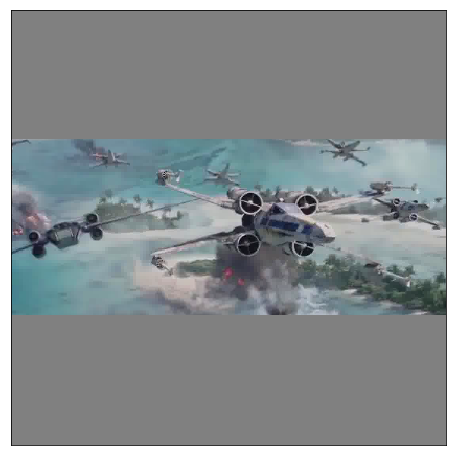

In [46]:
letterbox_img, letterbox_label = sample['img'], sample['label']
letterbox_img = np.ascontiguousarray(letterbox_img.numpy().transpose(1, 2, 0))
show_img(letterbox_img, figsize=(16,8))

In [47]:
def draw_labels_on_image(img, labels, classes_names, bbox_colors, font_scale=0.7, font=cv2.LINE_AA):
    for l in labels:
        if l.sum() == 0:
            break;

        box_coord = l[1:5]
        cls = l[0]

        cls_text = classes_names[cls.int().item()]
        cls_color = bbox_colors[cls.int()] 
        
        #box_coord = bbox_cxcywh_to_x1y1x2y2(box_coord.clone())

        #box_coord[[0,2]] = box_coord[[0,2]] * img.shape[1]
        #box_coord[[1,3]] = box_coord[[1,3]] * img.shape[0]

        pt1 = tuple(box_coord[0:2].int())
        pt2 = tuple(box_coord[2:4].int())

        img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img.shape[1], img.shape[0], font_scale=font_scale, font=font)

    show_img(img, figsize=(16,8))

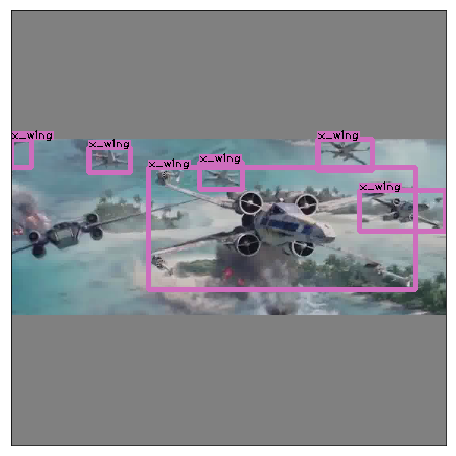

In [48]:
draw_labels_on_image(letterbox_img, letterbox_label, ['x_wing', 'tie'], get_color_pallete(20))

In [49]:
def letterbox_label_reverse(labels, x_off, y_off, resize_dim, new_dim, bbs_idx=np.arange(0,4)):
    if isinstance(labels, torch.Tensor):
        labels = labels.clone()
    elif isinstance(labels, np.ndarray):
        labels = labels.copy()
    else:
        raise TypeError("Labels must be a numpy array or pytorch tensor")
    ratio_x = resize_dim[0] / new_dim[0]
    ratio_y = resize_dim[1] / new_dim[1]
    x_idx, y_idx, cxw_idx, cyh_idx = bbs_idx[0], bbs_idx[1], bbs_idx[[0,2]], bbs_idx[[1,3]]  
    labels[..., x_idx] -= x_off
    labels[..., y_idx] -= y_off
    labels[..., cxw_idx] = np.clip((labels[..., cxw_idx] ) / ratio_x, 0, 1) 
    labels[..., cyh_idx] = np.clip((labels[..., cyh_idx] ) / ratio_y, 0, 1)
    return labels

In [50]:
lb_reverter = sample['lb_reverter']
img = sample['org_img']
img = np.ascontiguousarray(img.numpy().transpose(1, 2, 0))
img_w, img_h = img.shape[1], img.shape[0]


lb_reverter = torch.from_numpy(lb_reverter).double()
org_img, padded_dim, x_pad, y_pad = tuple(lb_reverter[0:2]), tuple(lb_reverter[2:4]), lb_reverter[4], lb_reverter[5]
letterbox_label = transforms.letterbox_reverter(letterbox_label, org_img, padded_dim, x_pad, y_pad, np.array([1,2,3,4]))

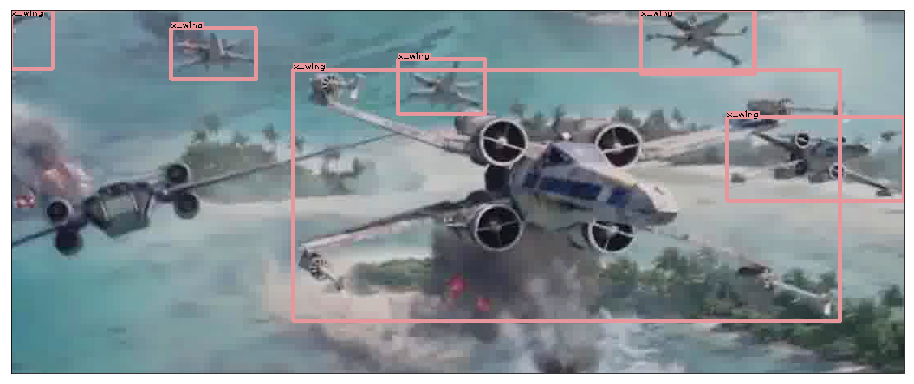

In [51]:
draw_labels_on_image(img, letterbox_label, ['x_wing', 'tie'], get_color_pallete(20))

# Extra Augmentations

In [52]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Affine (zoom, translate, rotate, shear)

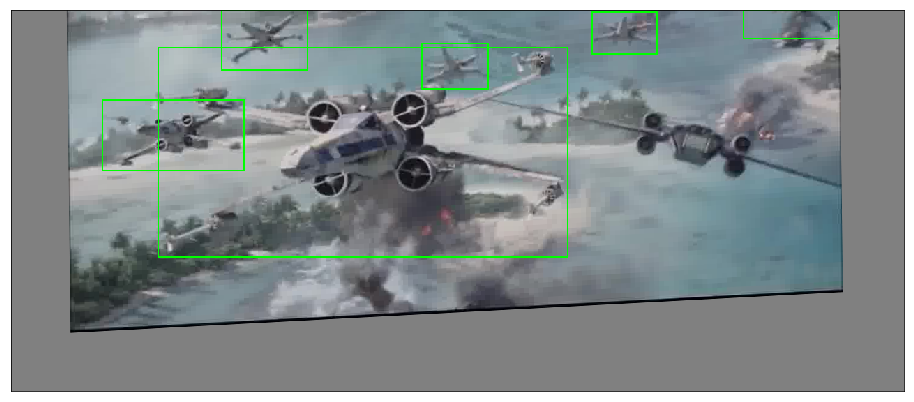

In [55]:
affine_seq = iaa.Sequential([iaa.AffineCv2(scale=(0.8, 1.2),
                                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                    rotate=(-5, 5),
                                    shear=(-3, 3),
                                    cval=128        ),
                     ]).to_deterministic()

letterbox_seq, _ = iaa_letterbox(aug_img, (416, 416))

aug_img, aug_bbs = iaa_run_seq(baseSeq, img, bbs)
aug_img, aug_bbs = iaa_run_seq(letterbox_seq, aug_img, aug_bbs)
aug_img, aug_bbs = iaa_run_seq(affine_seq, img, bbs)

aug_img = aug_bbs.draw_on_image(aug_img, thickness=2)
show_img(aug_img,  figsize=(16,8))

## List of possible augmentations we might used

In [56]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [57]:
aug_list = [iaa.GaussianBlur((3.0)),
            iaa.AverageBlur(k=(11)),
            iaa.MedianBlur(k=(11)),
            iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5)),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.05*255), per_channel=0.5),
            iaa.Add((-20, 20), per_channel=0.5),
            iaa.Multiply((0.8, 1.2), per_channel=0.5),
            iaa.ContrastNormalization((4), per_channel=0.5)
        ]
seq_list = [iaa.Sequential([aug]) for aug in aug_list]
img_list = np.array([img for _ in range(len(seq_list))])
aug_img_list = np.array([seq.augment_images([img])[0] for seq, img in zip(seq_list, img_list)])

(<matplotlib.axes._subplots.AxesSubplot at 0x7fea1c0d5f98>, (2184, 2560, 3))

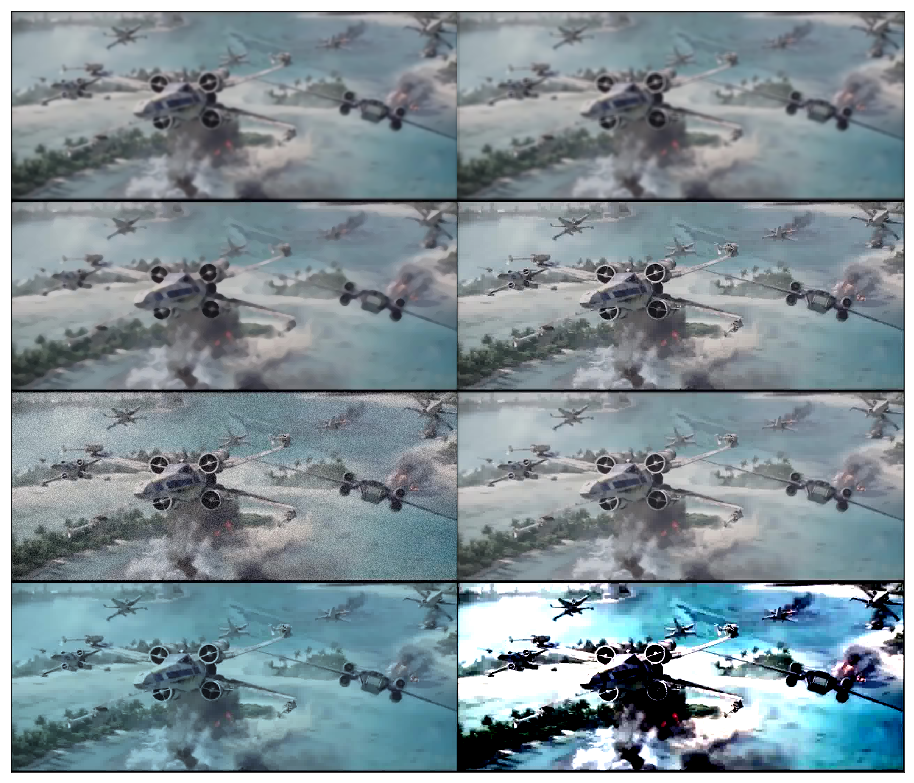

In [58]:
result = getImgGrid(aug_img_list, 2)
show_img(result,  figsize=(16,16)), result.shape

## Transform object

In [59]:
# Code copied from official Imaug doc and parameters taken from https://github.com/BobLiu20/YOLOv3_PyTorch

class ExtraAugmentations():
    def __init__(self):
        # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.seq = iaa.Sequential(
            [
                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                sometimes(iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5))),
                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
                # Add a value of -5 to 5 to each pixel.
                sometimes(iaa.Add((-5, 5), per_channel=0.5)),
                # Change brightness of images (80-120% of original value).
                sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
                # Improve or worsen the contrast of images.
                sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )

    def __call__(self, sample):
        seq_det = self.seq.to_deterministic()
        img, label = sample['img'], sample['label']
        img = seq_det.augment_images([img])[0]
        sample.update({'img': img, 'label': label})
        return sample

In [60]:
class COCOAugmentations():
    def __init__(self, out_dim, bbs_idx=[1,2,3,4], seed=1):
        self.out_dim = out_dim
        self.bbs_idx = bbs_idx
        self.baseSeq = iaa.Sequential([hsv_aug(0.1, 1.5, 1.5),
                                       random_crop(0.3),
                                       iaa.Fliplr(0.5)
                                      ])
        
        ia.seed(seed)
    
    def __call__(self, sample):
        img, label = sample['img'], sample['label']
        bbs = transforms.label_np_to_bbs(label, img.shape, bbs_idx=self.bbs_idx)

        # Base Augmentations - hsv, random crop, flip
        img, bbs = iaa_run_seq(self.baseSeq.to_deterministic(), img, bbs)

        # Letterbox transform
        img, bbs = iaa_run_seq(iaa_letterbox(img, self.out_dim), img, bbs)
        img = bbs.draw_on_image(img)
        
        label = transforms.label_bbs_to_np(bbs, bbs_idx=self.bbs_idx)
        sample.update({'img': img, 'label': label})
        return sample
        